# Total Correlation

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    import os
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")
    
finally:
    # import library functions
    from rbig_jax.data import get_classic
    from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
    from rbig_jax.models.itergauss import IterativeGaussianization
    from rbig_jax.information.total_corr import rbig_total_correlation

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Simple Dataset

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


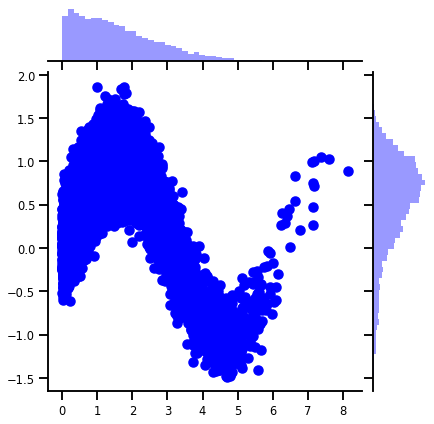

In [3]:
n_samples = 10_000
data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)

sns.jointplot(data[:, 0], data[:, 1], color="blue")

In [4]:
# initialize histogram transformation
n_samples = X.shape[0]
nbins = int(np.sqrt(n_samples))
support_extension = 10
precision = 1_000
alpha = 1e-5

# initialize total correlation transformation
zero_tolerance = 20

In [6]:

%%time

X_g, info_loss = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=True
)

CPU times: user 11.3 s, sys: 423 ms, total: 11.8 s
Wall time: 10.9 s


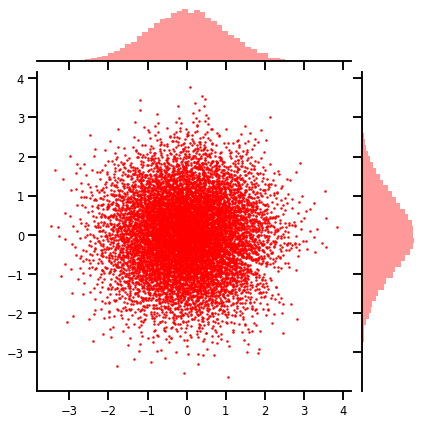

In [7]:
sns.jointplot(X_g[:, 0], X_g[:, 1], color="red", s=1)

In [8]:
print(info_loss.shape)

(38,)


In [9]:
base = 2
tc = np.sum(info_loss) * np.log(base)
print(f"RBIG TC: {tc}")

RBIG TC: 0.7492179877275595


In [10]:
%%time

tc = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=False
)
print(f"RBIG TC: {tc:.5f}")

RBIG TC: 0.74922
CPU times: user 10.6 s, sys: 42.2 ms, total: 10.7 s
Wall time: 10.3 s


## High-Dimensional Toy Data

In [11]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 30

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

# closed Form
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 35.2632


In [12]:
%%time


X = np.array(data, dtype=np.float32)

tc = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=False
)
print(f"RBIG TC: {tc:.5f}")

RBIG TC: 34.75812
CPU times: user 16.8 s, sys: 7.33 s, total: 24.1 s
Wall time: 13.1 s
